# This notebook is for the Fair-Shapely experiment

In [1]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [3]:
from src.data.unified_dataloader import load_dataset

a, processed_default_credit = load_dataset('default_credit')

In [4]:
processed_default_credit.head(3)

,LIMIT_BAL,sex,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,...,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8,default_payment_next_month
0,-1.136720,0,-1.246020,-0.642501,-0.647399,-0.667993,-0.672497,-0.663059,-0.652724,-0.341942,...,0,0,0,0,0,0,0,0,0,1
1,-0.365981,0,-1.029047,-0.659219,-0.666747,-0.639254,-0.621636,-0.606229,-0.597966,-0.341942,...,0,0,1,0,0,0,0,0,0,1
2,-0.597202,0,-0.161156,-0.298560,-0.493899,-0.482408,-0.449730,-0.417188,-0.391630,-0.250292,...,0,1,0,0,0,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [ ]:
'''Default_credit dataset'''
df = processed_default_credit.copy()
X = df.drop('default_payment_next_month', axis=1)
y = df['default_payment_next_month']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (21000, 90)
X_test shape: (9000, 90)


### 4. Train the original model

In [6]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.8133333333333334


In [7]:
X_train['sex'].value_counts()

sex
0    12667
1     8333
Name: count, dtype: int64

In [8]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [9]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')


c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


original_test_DR: 0.01625891402363777
original_train_DR: 0.01571783237159252


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据


c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.l

4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据


c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.log(2 * np.pi * self.noise_variance_)
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2300: RuntimeWarning: invalid value encountered in divide
  + residuals_sum_squares / self.noise_variance_
c:\Users\ZhuLi\Anaconda3\envs\unlabel_fair\lib\site-packages\sklearn\linear_model\_least_angle.py:2299: RuntimeWarning: divide by zero encountered in log
  n_samples * np.l

5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 14
shapely value中大于0.1的值的个数有: 18


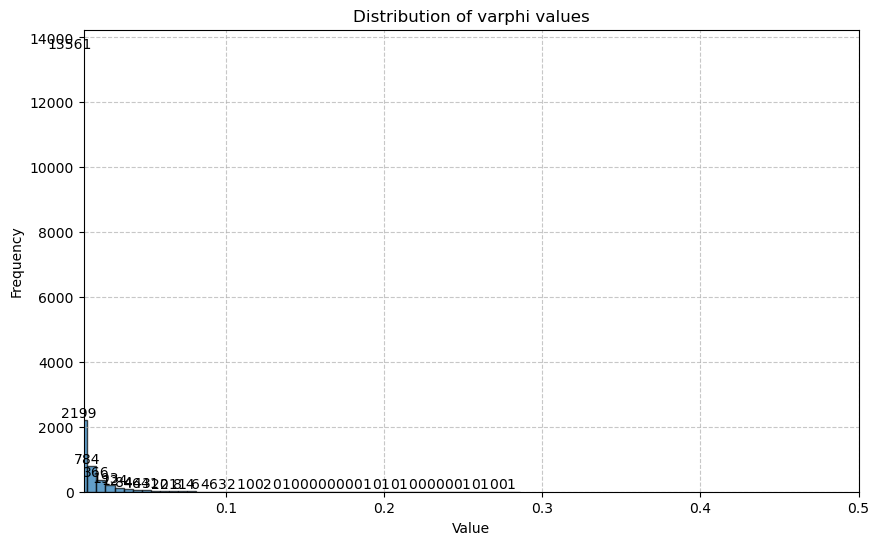

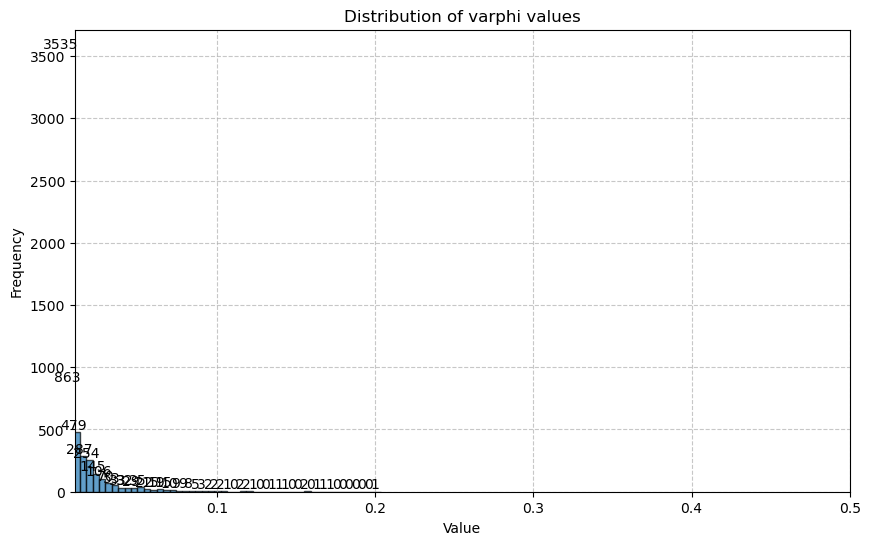

6. 开始整理并且合并新数据,共修改32个数据点, 使用new training set训练新模型
changed_value_info.shape: 31


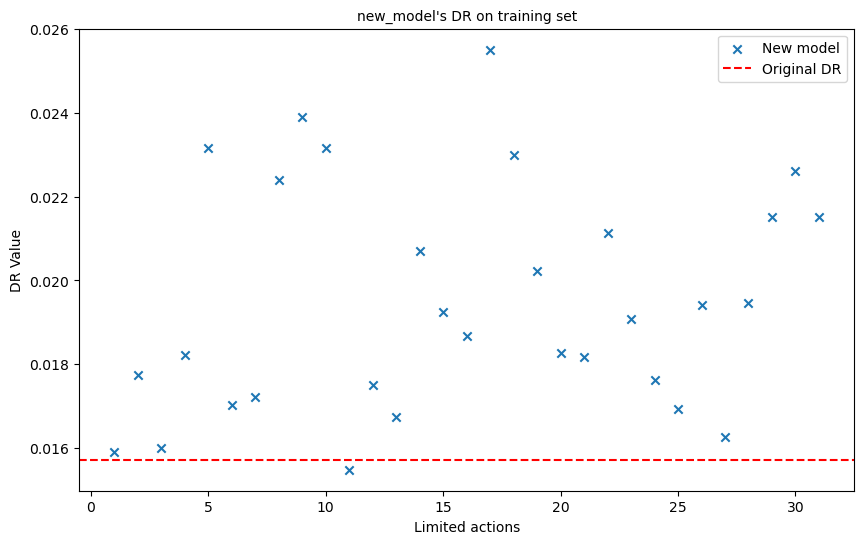

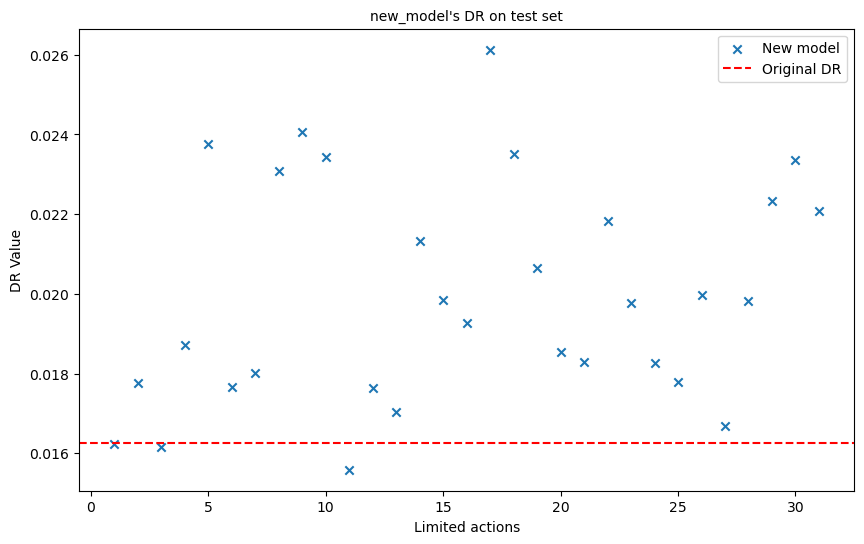

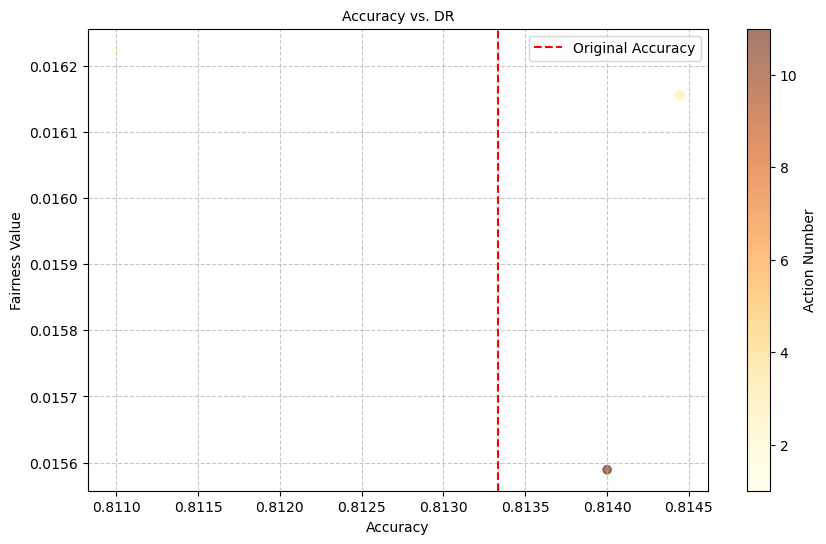

([0.016224727,
  0.01777447,
  0.016155554,
  0.018728657,
  0.023770258,
  0.017653415,
  0.01802304,
  0.023090063,
  0.024067674,
  0.023437295,
  0.015589105,
  0.017637424,
  0.017036555,
  0.02131739,
  0.019844962,
  0.019279936,
  0.026125483,
  0.023514755,
  0.020642659,
  0.018538367,
  0.018291425,
  0.021826433,
  0.0197783,
  0.018275853,
  0.017796589,
  0.019975506,
  0.016680265,
  0.019823138,
  0.022337915,
  0.023358403,
  0.022085303],
 [(0.016224727, 0.811, 1),
  (0.016155554, 0.8144444444444444, 3),
  (0.015589105, 0.814, 11)])

In [10]:
from src.experiments_approach2 import ExperimentNew
from src.experiments_approach3 import ExperimentNew2

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='default_credit',
                            change_group = 'minority')
experiment.run_experiment()


In [ ]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='default_credit',
                            change_group = 'majority')
experiment2.run_experiment()

2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据


In [59]:
''' Experiment new

1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority
2. 将X_train_minority与X_train_replace_majority进行匹配
3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点
4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new
5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值

----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------
'''

' Experiment new\n\n1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority\n2. 将X_train_minority与X_train_replace_majority进行匹配\n3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点\n4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new\n5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值\n\n----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------\n'